# Validación  del modelo

Una pieza muy importante del machine learning es la **validación del modelo**, esto es, determinar como de bien generalizará nuestro modelo en datos no etiquetados que todavía no ha visto.

Para los ejemplos, ahora vamos a trabajar con unos nuevos datos.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')

In [3]:
from sklearn.datasets import load_digits

digits = load_digits()
X = digits.data
y = digits.target

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (1797, 64)
y shape: (1797,)


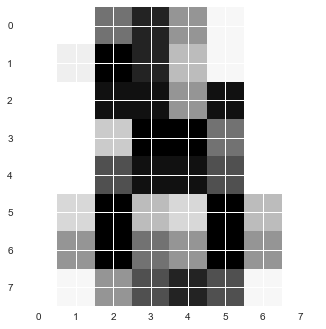

In [4]:
plt.imshow(X[-1, :].reshape(8, 8));

Vamos a ajustar un KNN a nuestros datos:

In [5]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X, y)

KNeighborsClassifier(n_neighbors=1)

Ahora usamos el clasificador que hemos estimado para hacer predicciones:

In [6]:
y_pred = knn.predict(X)

Para terminar, comprobamos la precisión de nuestro clasificador:

In [7]:
print(f"{np.sum(y == y_pred)} / {len(y)} correct")

1797 / 1797 correct


Al parecer, nuestro clasificador es perfecto. 

**Pregunta: ¿Que hemos hecho mal aquí?**

## Conjunto de validación

En el anterior ejemplo hemos cometido el error de evaluar nuestro modelo en el mismo conjunto de datos que hemos utilizado para entrenar. **Esto es una mala idea.** Si optimizamos nuestro modelo de estimación de está manera, acabaremos teniendo un problema de **over-fiting**.

Un método mejor para evaluar nuestro modelo es utilizar para ello un conjunto de datos separado en el que el modelo no haya entrenado.

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
X_train.shape, X_test.shape

((1347, 64), (450, 64))

Ahora, vamos a entrenar en el conjunto de entrenamiento y evaluar el modelo en el conjunto de test:

In [9]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(f"{np.sum(y_test == y_pred)} / {len(y_test)} corret")

446 / 450 corret


Esto nos da una imágen más realista de como lo está haciendo nuestro modelo.

Al comparar el número de coincidencias con el número total de instancias estamos calculando la métrica conocida como **exactitud** o **accuracy**. Podemos calcularla de otra forma:

In [10]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.9911111111111112

In [11]:
knn.score(X_test, y_test)

0.9911111111111112

Podemos estudiar como cambia la **accuracy** al cambiar el valor del **hiperparametro** de nuestro modelo:

In [12]:
for n_neighbors in [1, 5, 10, 20, 30]:
    knn = KNeighborsClassifier(n_neighbors)
    knn.fit(X_train, y_train)
    print(n_neighbors, knn.score(X_test, y_test))

1 0.9911111111111112
5 0.98
10 0.9755555555555555
20 0.9644444444444444
30 0.9555555555555556


Podemos observar que al parecer, elegir un número pequeño de vecinos es la mejor opción.

## Cross-Validation

El problema de tener que guardar un subconjunto de nuestro conjunto de datos para hacer la evaluación es que a veces nos podemos quedar sin datos suficientes para poder entrenar un algoritmo que desempeñe bien su tarea.

La **validación cruzada** o **cross-validation** es un es una técnica utilizada para evaluar los resultados de un análisis estadístico y garantizar que son independientes de la partición entre datos de entrenamiento y prueba. Consiste en repetir y calcular la media aritmética obtenida de las medidas de evaluación sobre diferentes particiones.

In [13]:
X1, X2, y1, y2 = train_test_split(X, y, test_size=0.5, random_state=0)
X1.shape, X2.shape

((898, 64), (899, 64))

In [14]:
print(KNeighborsClassifier(1).fit(X2, y2).score(X1, y1))
print(KNeighborsClassifier(1).fit(X1, y1).score(X2, y2))

0.9832962138084632
0.982202447163515


In [15]:
print((KNeighborsClassifier(1).fit(X2, y2).score(X1, y1) + KNeighborsClassifier(1).fit(X1, y1).score(X2, y2)) / 2)

0.9827493304859891


En la API de scikit-learn tenemos implementado un método para hacer esto mucho más rápido:

In [16]:
from sklearn.model_selection import cross_val_score

cv = cross_val_score(KNeighborsClassifier(n_neighbors=1), X, y, cv=2)
print(cv)
print(cv.mean())

[0.96329255 0.95991091]
0.9616017302075308


## K-fold Cross-Validation

En los anteriores ejemplos, hemos usado un 2-fold cross-validation. Esto es un ejemplo concreto de K-fold cross-validation. Con esta técnica, creamos K particiones independientes del conjunto de datos principal, y para cada partición, entrenamos en el resto de dataset y luego evaluamos nuestro modelo en la partición que hemos guardado. Así, tendremos K métricas, una para cada fold. El número de particiones, K, lo especificamos con el parámetro `cv`.

In [17]:
cross_val_score(KNeighborsClassifier(1), X, y, cv=10)

array([0.93333333, 0.99444444, 0.97222222, 0.97222222, 0.96666667,
       0.98333333, 0.99444444, 0.98882682, 0.97765363, 0.96648045])

Con esto, conseguimos una mejor imágen de como funciona nuestro modelo.

## Overfitting, Underfitting y selección del modelo

Elegir el mejor modelo posible es una cuestión de lo más importante en el campo del aprendizaje automático. Pero esta tarea puede ser complicada.

Hay una serie de preguntas que tenemos que hacernos si nuestro modelo no obtiene buenos resultado:

* ¿Tenemos que usar un modelo más complicado o mas sencillo?
* ¿Deberíamos de usar más características en nuestro estimador?
* ¿Necesitamos más datos para lograr mejores estimadores?

No hay un resultado correcto para estas preguntas. A veces, nos vamos a encontrat con que un modelo más complicado va a obtener todavía peores resultados. Otras veces, el hecho de conseguir más instancias para aprender tampoco nos va ayudar. El hecho de ser capazes de determinar que pasos nos van a ayudar a mejorar nuestro modelo es algo fundamental.

### Bias-Variance Tradeoff

Vamos a analizar este problema visualmente con un ejemplo de regresión.

In [18]:
def test_func(x, err=0.5):
    y = 10 - 1. / (x + 0.1)
    if err > 0:
        y = np.random.normal(y, err)
    return y

In [19]:
def make_data(N=40, error=1.0, random_seed=1):
    # randomly sample the data
    np.random.seed(1)
    X = np.random.random(N)[:, np.newaxis]
    y = test_func(X.ravel(), error)
    
    return X, y

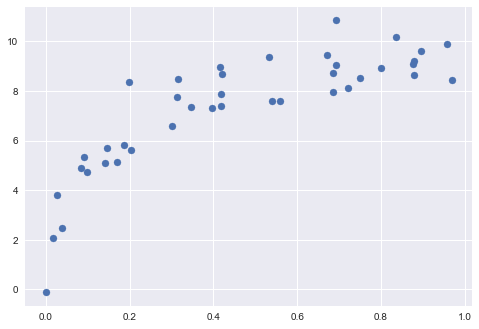

In [20]:
X, y = make_data(40, error=1)
plt.scatter(X.ravel(), y);

Vamos a usar una regresión lineal para estimar un modelo a partir de los datos.

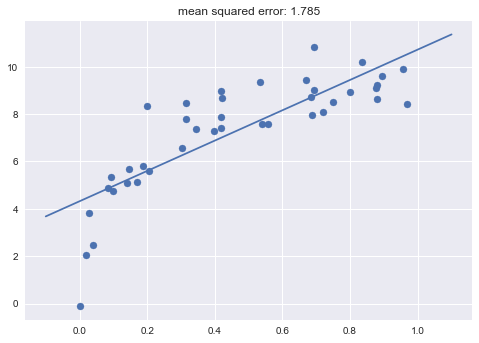

In [21]:
X_test = np.linspace(-0.1, 1.1, 500)[:, None]

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
model = LinearRegression()
model.fit(X, y)
y_test = model.predict(X_test)

plt.scatter(X.ravel(), y)
plt.plot(X_test.ravel(), y_test)
plt.title(f"mean squared error: {mean_squared_error(model.predict(X), y):.3f}");

Hemos ajustado una linea recta a los datos, pero está claro que este modelo no es muy buena opción por que no representa la relación entre los diferentes puntos muy bien. Tenemos un error de **bias** o un problema de **underfitting**.

Vamos a intentar mejorar el resultado utilizando modelos más complicados. Para ello, vamos a usar el método de `PolynomialFeatures` que nos da la API de scikit-learn para preprocesar los datos y así crear nuevas caracteristicas con combinaciones polinomiales de las características originales. Usando el método `make_pipeline` lo juntamos con la regresión.

In [22]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), LinearRegression(**kwargs))

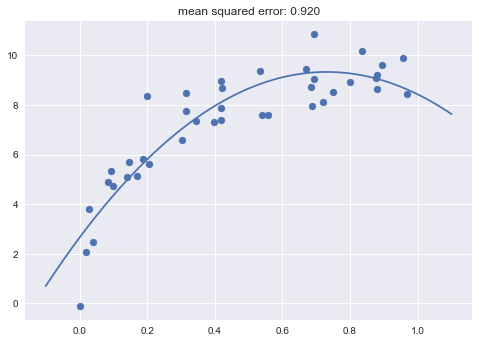

In [23]:
model = PolynomialRegression(2)
model.fit(X, y)
y_test = model.predict(X_test)

plt.scatter(X.ravel(), y)
plt.plot(X_test.ravel(), y_test)
plt.title(f"mean squared error: {mean_squared_error(model.predict(X), y):.3f}");

Este modelo ha conseguido reducir el error cuadrático medio y se ajusta mejor a los datos. ¿Que sucede si añadimos componentes con mayor grado a nuestra regresiñon polinómica? 

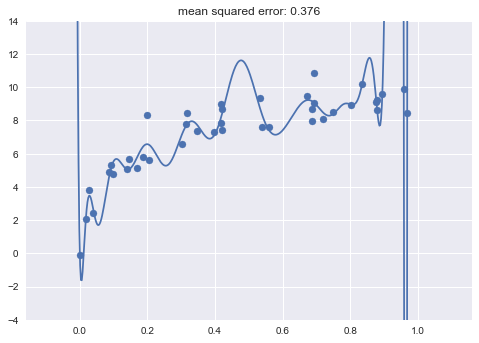

In [24]:
model = PolynomialRegression(30)
model.fit(X, y)
y_test = model.predict(X_test)

plt.scatter(X.ravel(), y)
plt.plot(X_test.ravel(), y_test)
plt.title(f"mean squared error: {mean_squared_error(model.predict(X), y):.3f}")
plt.ylim(-4, 14);

Cuando hemos aumentado el grado de la regresión polinómica, vemos que llegamos a un punto en el que el modelo que inferimos no refleja nada bien la distribución subyacente de nuestors datos. Además, nuestro modelo es mas sensitivo al ruido que tenemos en nuestro conjunto de entrenamiento. Por eso decimos que nuestro modelo tiene un problema de **overfitting**.

### Detectar problemas de over-fitting con las curvas de validación

Calcular el error solamente en los datos de entrenamiento no es suficiente. Por lo tanto, vamos a usar la validación cruzada para entender mejor como de bien está funcionando nuestro modelo.

Vamos a usar las curvas de validación y un dataset más grande para ver las cosas con más claridad:

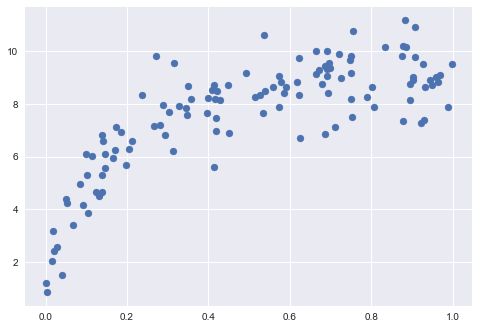

In [25]:
X, y = make_data(120, error=1.0)
plt.scatter(X, y);

In [26]:
from sklearn.model_selection import validation_curve

def rms_error(model, X, y):
    y_pred = model.predict(X)
    return np.sqrt(np.mean((y - y_pred) ** 2))

degree = np.arange(0, 18)
val_train, val_test = validation_curve(PolynomialRegression(), X, y,
                                       param_name='polynomialfeatures__degree', 
                                       param_range=degree,
                                       cv=7, scoring=rms_error)

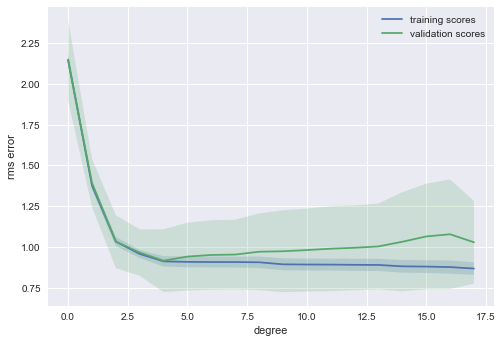

In [27]:
def plot_with_err(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, '-', **kwargs)
    plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                     facecolor=lines[0].get_color(), alpha=0.2)

plot_with_err(degree, val_train, label='training scores')
plot_with_err(degree, val_test, label='validation scores')
plt.xlabel('degree'); plt.ylabel('rms error')
plt.legend();

Vamos a fijarnos en la tendencía que se puede observar en el gráfico:

1. Cuando utilizamos modelos muy poco complejos, vemos que tanto el error en conjunto de entrenamiento como en el validación son bastante altos y similares. Esto nos indica que tenemos un problema de **underfitting**: el modelo no tiene complejidad suficiento como para representar los datos debidamente (**high-bias**).

2. A medida que la complejidad del modelo va creciendo, vemos que los errores de ambos conjunto disminuyen. Esto nos indica que el modelo se esta ajustando a los datos.

3. Por último, vemos que hay un punto en el que el error de validación deja de decrecer por más que la complejidad del modelo sigue aumentando, incluso aumenta un poco. Esto nos indica que empezamos a tener un problema de **overfitting** (o **high-variance**). El error de entrenamiento sigue mejorando pero esto se debe a que un modelo más complicado puede modelar mejor el ruido del conjunto de entrenamiento.

El mejor modelo según el gráfico de arriba, sería con un grado polinomial de 4:

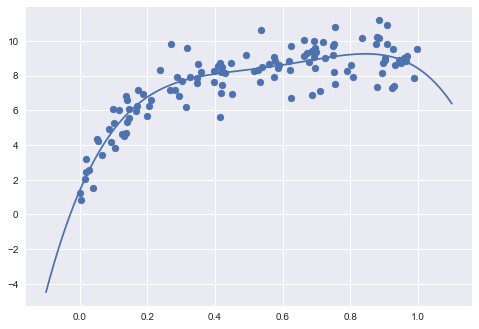

In [28]:
model = PolynomialRegression(4).fit(X, y)
plt.scatter(X, y)
plt.plot(X_test, model.predict(X_test));

## Búsqueda de hiperparámetros

Los hiperparámetros de un modelo de aprendizaje automático son parámetros que se utilizan para controlar el proceso de aprendizaje. Por lo tanto, estos parámetros no se especifican antes de ajustar el modelo a los datos. Por ejemplo, en el algoritmo KNN, el número de vecinos es el hiperparámetro más importante, además de la métrica de distancia. 

In [29]:
from sklearn.datasets import load_digits
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

digits = load_digits()
X = digits.data
y = digits.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

knn = KNeighborsClassifier()

param_grid = {'n_neighbors': [1, 5, 10, 20], 'metric': ('euclidean', 'manhattan', 'chebyshev')}

search = GridSearchCV(knn, param_grid, cv=5).fit(X_train, y_train)

In [30]:
search.best_estimator_

KNeighborsClassifier(metric='euclidean')

In [33]:
search.best_estimator_.score(X_test, y_test)

0.98

In [31]:
search.best_score_

0.9858846206801598

In [32]:
import pandas as pd

pd.DataFrame(search.cv_results_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_metric  \
0        0.014536      0.002122         0.040941        0.002162    euclidean   
1        0.012997      0.001095         0.039627        0.002615    euclidean   
2        0.011402      0.000490         0.037456        0.001205    euclidean   
3        0.011789      0.000392         0.038464        0.000770    euclidean   
4        0.012969      0.000673         0.031344        0.001917    manhattan   
5        0.012159      0.000686         0.032205        0.000987    manhattan   
6        0.012794      0.000391         0.034054        0.001001    manhattan   
7        0.012352      0.000412         0.034568        0.001731    manhattan   
8        0.012436      0.000589         0.031812        0.002274    chebyshev   
9        0.012549      0.000468         0.034837        0.000656    chebyshev   
10       0.012615      0.001945         0.034643        0.002801    chebyshev   
11       0.013410      0.002317         0.039238        0.002205    chebyshev   

   param_n_neighbors                                      params  \
0                  1   {'metric': 'euclidean', 'n_neighbors': 1}   
1                  5   {'metric': 'euclidean', 'n_neighbors': 5}   
2                 10  {'metric': 'euclidean', 'n_neighbors': 10}   
3                 20  {'metric': 'euclidean', 'n_neighbors': 20}   
4                  1   {'metric': 'manhattan', 'n_neighbors': 1}   
5                  5   {'metric': 'manhattan', 'n_neighbors': 5}   
6                 10  {'metric': 'manhattan', 'n_neighbors': 10}   
7                 20  {'metric': 'manhattan', 'n_neighbors': 20}   
8                  1   {'metric': 'chebyshev', 'n_neighbors': 1}   
9                  5   {'metric': 'chebyshev', 'n_neighbors': 5}   
10                10  {'metric': 'chebyshev', 'n_neighbors': 10}   
11                20  {'metric': 'chebyshev', 'n_neighbors': 20}   

    split0_test_score  split1_test_score  split2_test_score  \
0            0.970370           0.985185           0.988848   
1            0.988889           0.996296           0.973978   
2            0.977778           0.981481           0.973978   
3            0.962963           0.970370           0.962825   
4            0.977778           0.977778           0.973978   
5            0.981481           0.992593           0.970260   
6            0.962963           0.977778           0.962825   
7            0.966667           0.959259           0.959108   
8            0.970370           0.977778           0.973978   
9            0.974074           0.974074           0.970260   
10           0.959259           0.974074           0.966543   
11           0.955556           0.959259           0.966543   

    split3_test_score  split4_test_score  mean_test_score  std_test_score  \
0            0.988848           0.988848         0.984420        0.007166   
1            0.985130           0.985130         0.985885        0.007216   
2            0.977695           0.985130         0.979212        0.003793   
3            0.970260           0.970260         0.967336        0.003627   
4            0.981413           0.977695         0.977728        0.002351   
5            0.977695           0.985130         0.981432        0.007443   
6            0.970260           0.977695         0.970304        0.006638   
7            0.955390           0.973978         0.962880        0.006647   
8            0.988848           0.985130         0.979221        0.006863   
9            0.988848           0.985130         0.978477        0.007185   
10           0.966543           0.981413         0.969566        0.007552   
11           0.947955           0.966543         0.959171        0.007036   

    rank_test_score  
0                 2  
1                 1  
2                 5  
3                10  
4                 7  
5                 3  
6                 8  
7                11  
8                 4  
9                 6  
1

# Flow chart: Como elegir el Estimator

El siguiente [diagrama de flujo](http://scikit-learn.org/stable/tutorial/machine_learning_map/), creado por [Andreas Muller](https://github.com/amueller), nos da una visión general de que algoritmos podemos elegir en diferentes situaciones.

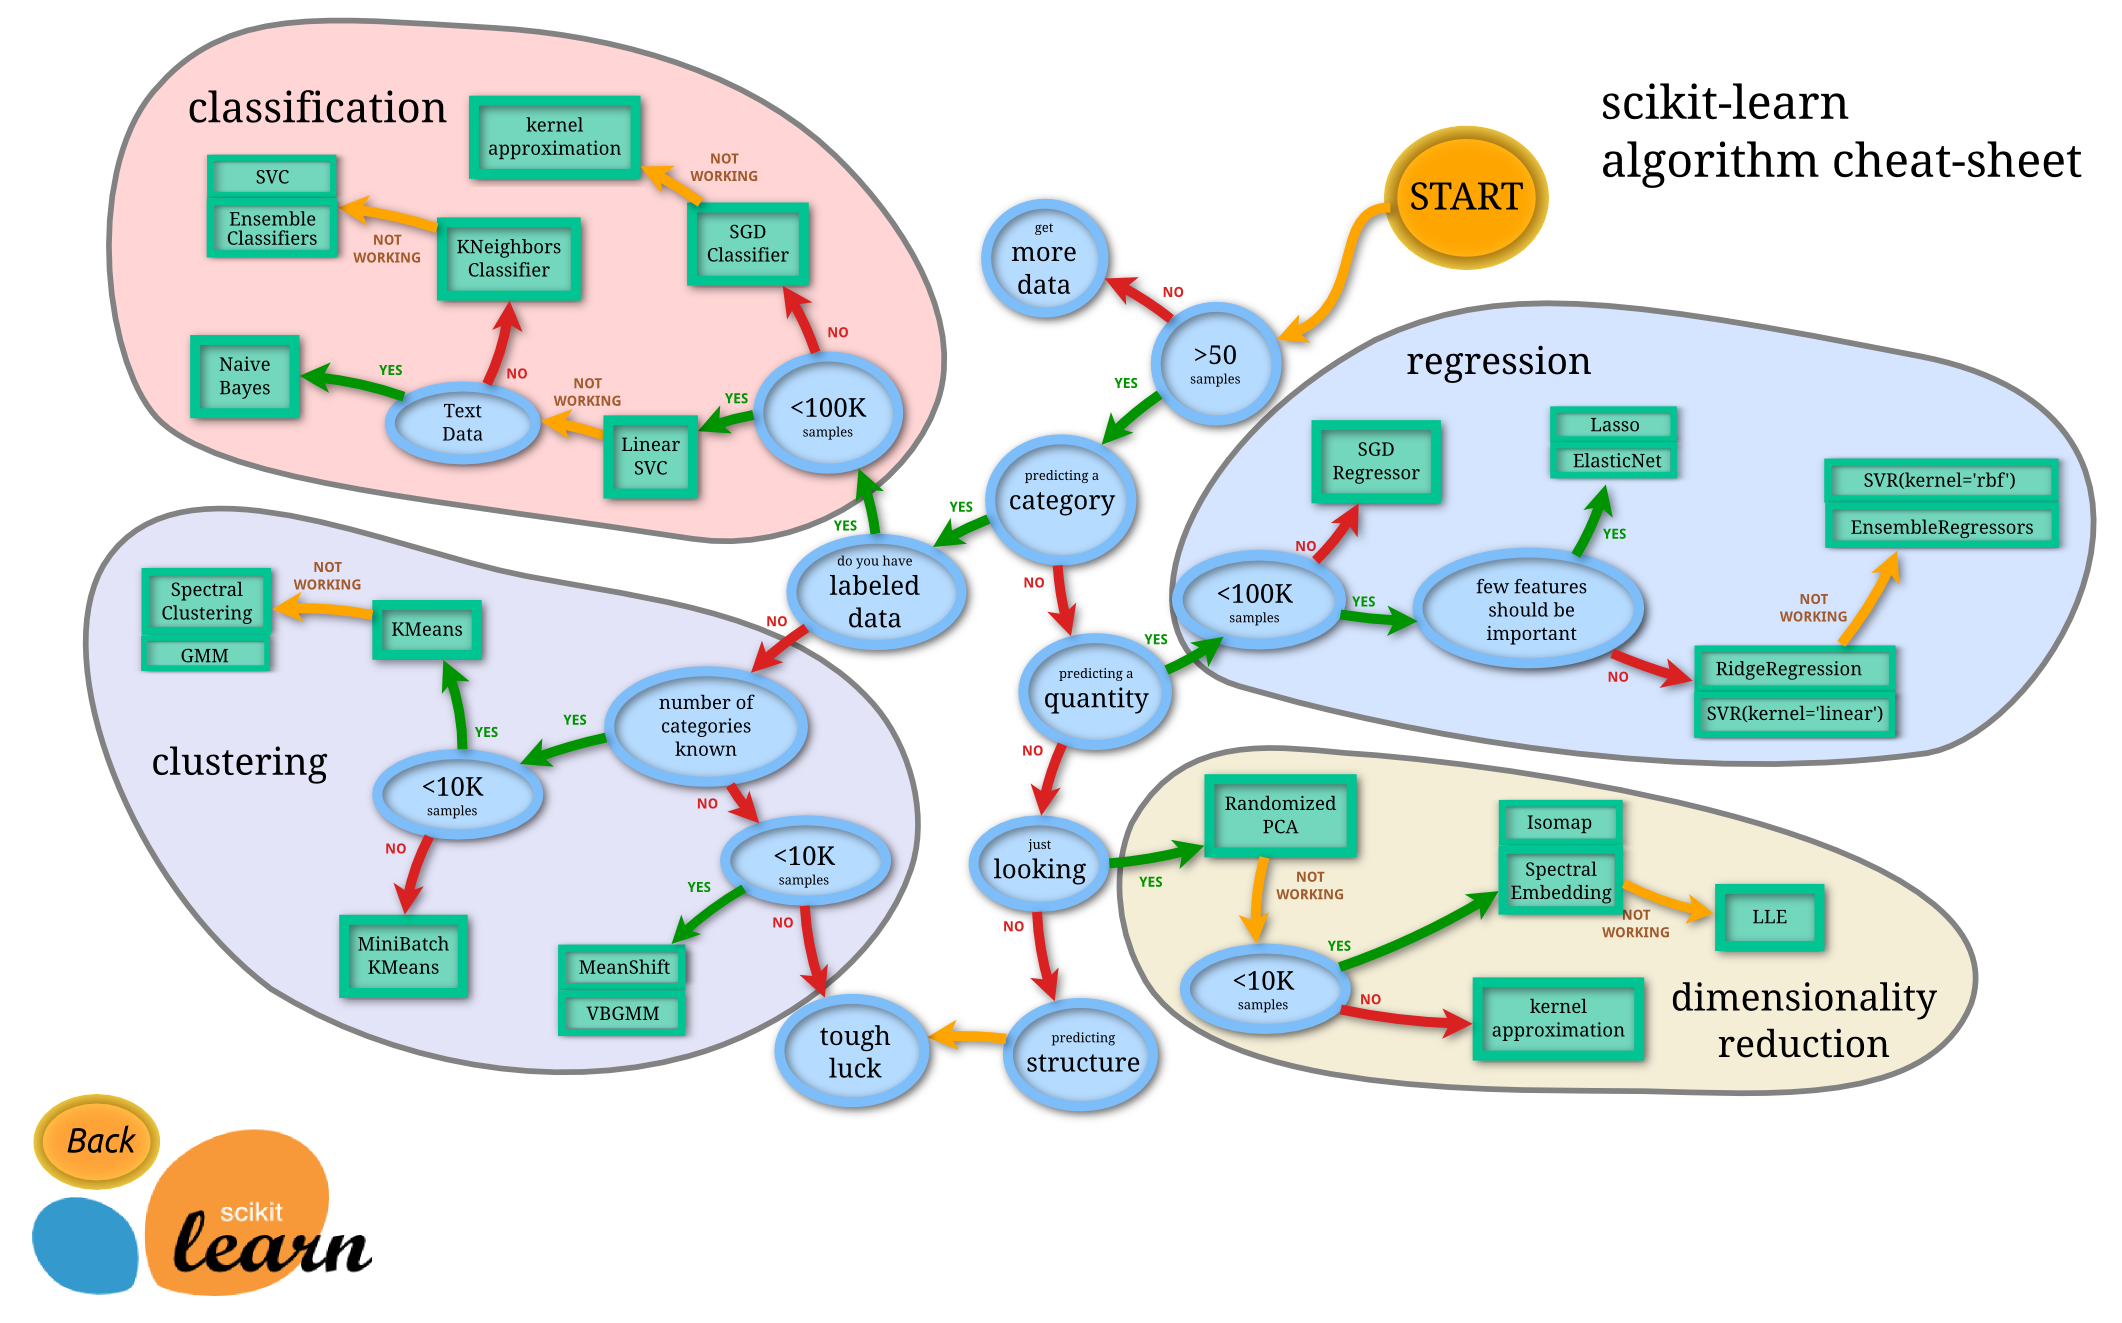

In [4]:
from IPython.display import Image
Image("http://scikit-learn.org/dev/_static/ml_map.png")